# NB8 - Reproducing Cambridge Analytica's work

Cambridge Analytica was a London-based company founded in 2013, specializing in Big Data analysis and the application of psychological profiling. One of their most well-known methods was based on the Big Five personality traits, also known as the OCEAN model. The OCEAN model suggests that human personality can be described using five broad dimensions:

* **Extraversion** : Reflects a person's tendency to seek stimulation in the company of others. High scorers are outgoing, talkative, and energetic, while low scorers tend to be reserved and prefer solitary activities.
* **Neuroticism** : Measures emotional stability and the tendency to experience negative emotions like anxiety, sadness, or irritability. Higher scores indicate greater emotional sensitivity, while lower scores suggest calm and resilience under stress.
* **Agreeableness** : Captures the extent to which a person is cooperative, empathetic, and willing to help others. High scorers are compassionate and trusting, while low scorers may be more competitive or skeptical of others' motives.
* **Conscientiousness** : Describes a person’s level of self-discipline, organization, and goal-directed behavior. High scorers are diligent, detail-oriented, and reliable, while low scorers may be more spontaneous or less focused on long-term goals.
* **Openness** : Reflects a person's openness to new experiences, creativity, and curiosity. High scorers are imaginative and adventurous, while low scorers prefer routine and are more traditional in their views.

In addition to psychological profiling, Cambridge Analytica’s services were employed by various political campaigns globally, most notably by candidates such as Ben Carson, Ted Cruz, and Donald Trump during the 2016 U.S. presidential election. The company faced significant controversy for allegedly harvesting personal data from millions of Facebook users. They used a quiz, which users voluntarily completed, to gather information about individuals' personalities. This data, combined with users' social connections, posts, and likes, enabled Cambridge Analytica to target potential voters for political campaigns, influencing their strategies.

In this notebook, we aim to replicate a simplified version of this work, but without the ethical concerns. Instead of illicitly collecting data, we use publicly available responses to the OCEAN personality test. As outlined in the supplementary Python files, we generated a target column to simulate identifying individuals who might be inclined to vote for a particular political candidate. The goal is to explore how personality traits could potentially correlate with political preferences in a machine learning context.

This is not 100% accurate, but the main ideas are the ones that were used by Cambridge Analytica. The steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

df = pd.read_csv("Analytica.csv")

OCEAN = {
    "EXT": "Extraversion",
    "EST": "Neuroticism",
    "AGR": "Agreeableness",
    "CSN": "Conscientiousness",
    "OPN": "Openness"
}
dimensions = list(OCEAN.keys())

df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,EXT_time,EST,EST_time,AGR,AGR_time,CSN,CSN_time,OPN,OPN_time,target
0,3.0,2.0,2.0,4.0,4.0,4.0,5.0,3.0,1.0,3.0,...,72.625,0.44,46.155,0.24,82.665,0.10,62.022,0.10,40.415,NaN
1,3.0,4.0,1.0,4.0,3.0,2.0,2.0,4.0,3.0,5.0,...,45.790,0.42,36.420,-0.14,86.422,0.10,56.401,0.26,38.205,0.0
2,3.0,3.0,4.0,4.0,5.0,3.0,3.0,5.0,2.0,2.0,...,64.250,0.42,50.268,0.50,58.487,0.18,44.737,0.34,51.454,NaN
3,1.0,5.0,1.0,5.0,2.0,4.0,1.0,5.0,3.0,5.0,...,50.384,0.64,59.489,0.22,59.080,0.18,66.815,0.32,58.911,NaN
4,1.0,4.0,3.0,5.0,1.0,2.0,2.0,4.0,2.0,4.0,...,59.927,0.46,39.848,0.40,97.554,0.24,45.858,0.42,48.390,0.0


## Analysis

We have 10 question per dimension, and the time in second taken to respond to each question. We also have the overall score for each dimension and the time take to answer all of the questions.
Let's first have a look at the distribution for the overall scores.

**Task** : Using the code in the following cell, analyse its output.

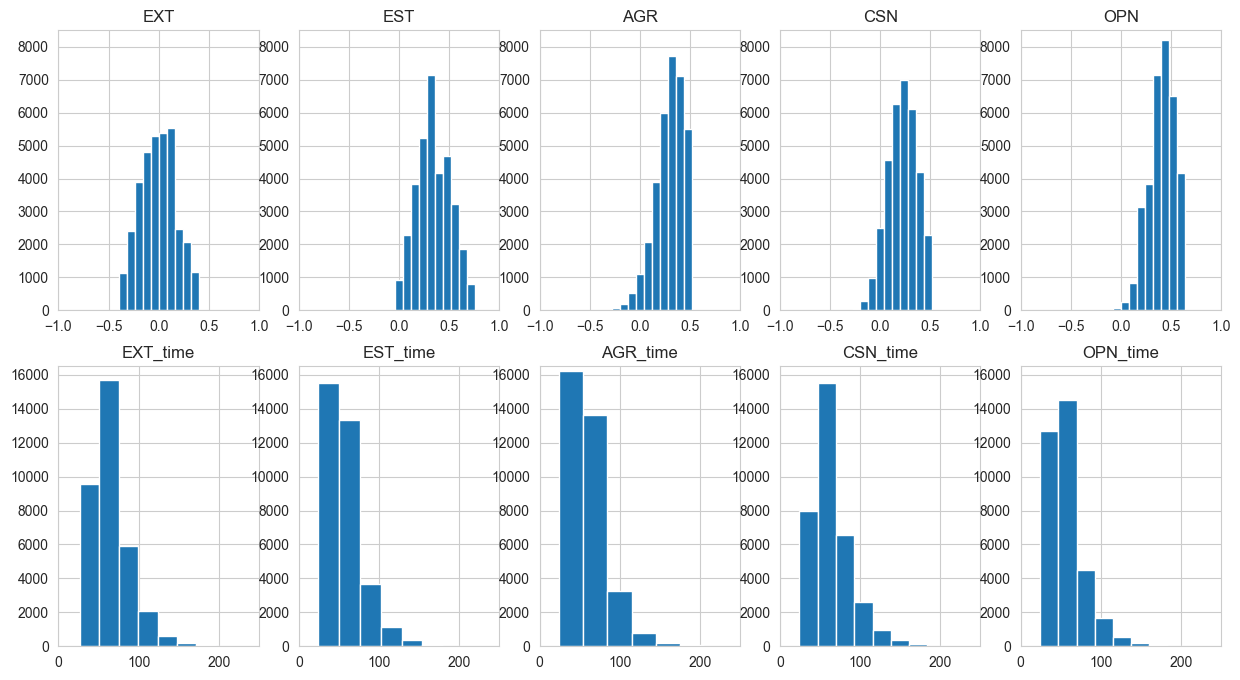

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style="whitegrid")

plt.figure(figsize=(15, 8))

for index in range(1, 6):
    plt.subplot(2, 5, index)
    column = dimensions[index-1]
    plt.hist(df[column])
    plt.xlim(-1, 1)
    plt.ylim(0, 8500)
    plt.title(column)

    plt.subplot(2, 5, index+5)
    column = column + "_time"
    plt.hist(df[column])
    plt.xlim(0, 250)
    plt.ylim(0, 16500)
    plt.title(column)

plt.show()

Before diving in the modelisation, one need to check for missing values.

**Task** : Using the [`isna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html) method along with the [`sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html#pandas.DataFrame.sum) method, look for missing values in the dataset. As there is 100+ columns, only display the ones with missing values.

In [3]:
vector = df.isna().sum()

if vector.sum() > 0:
    vector = vector[vector > 0]
    for index, value in zip(vector.index, vector):
        column = value
        print(f"{index}: {value} missing ({100 * value/df.shape[0]:.2f}%)")
else:
    print("No missing values")

target: 29067 missing (85.08%)


As expected, we have only 15% *target* variable available. Our goal is to regroup people that *looks* the same and then project the target into the groups.

## Modelisation

But first, as we saw, we need to scale all the distributions.

**Task** : Extract from the dataframe all the columns except the target one, then use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class. Keep the target in a vector named *y* for convenience.

In [4]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["target", "ID"])
y = df["target"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

As we have 112 columns, we should first reduce the dimension of our dataset.

### PCA

We will use [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (Principal Component Analysis) to do this.

**Task** : Reduce the dimension to 20 variables using the `fit` then `transform` method.

In [5]:
from sklearn.decomposition import PCA

n_components = 20
model_pca = PCA(n_components=n_components)
model_pca.fit(X)
X_pca = model_pca.transform(X)

Can we measure how *good* our PCA is ? The theory tells that the sum of all the eigenvalue of dimension is equal to the overall variance of the dataset. Here we kept only 20 over 112, so how much of variance did we *explained* ?

**Task** : Using the `explained_variance_ratio` attribute in the PCA model, answer the question.

In [6]:
ratio = model_pca.explained_variance_ratio_.sum()
print(f"We explained {100 * ratio:.2f}% of the global variance.")

We explained 50.25% of the global variance.


So we kept ~50% of the variance using only 18% dimensions (20 / 111) which is good but not great. We will try to improve this part later.

### KMeans

As we have a smaller dataset in terms of dimension, the KMeans algorithm can be used.

**Task** : Using the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, get a vector named *cluster* which is the result of the `predict` method of [`KMeans`] class. We will build 5 clusters.

In [7]:
from sklearn.cluster import KMeans

n_clusters = 5
model = KMeans(n_clusters=n_clusters)
model.fit(X_pca)
cluster = model.predict(X_pca)

And... is it good ? We do not have any ground truth this time, but we can look at the [`silhouette score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) function to have an idea of how well cluster are shaped.

**Task** : Compute and analyse the silhouette score of our model.

In [8]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X=X_pca, labels=cluster)
print(f"Silhouette score = {score:.4f}")

Silhouette score = 0.0773


It is not great... We will improve this value but we need to *understand* what the clusters are about.

### Analysis

**Task** : Extract for the original dataframe the 5 overall score and the target in a dataframe, then add the predicted cluster.

In [9]:
study = df[dimensions + ["target"]]
study["Cluster"] = cluster
study.head()

/var/folders/lf/gcppmty149qbrnk_k09vzs040000gn/T/ipykernel_53243/3807522779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study["Cluster"] = cluster


,EXT,EST,AGR,CSN,OPN,target,Cluster
0,-0.02,0.44,0.24,0.10,0.10,NaN,3
1,-0.14,0.42,-0.14,0.10,0.26,0.0,4
2,0.00,0.42,0.50,0.18,0.34,NaN,1
3,-0.32,0.64,0.22,0.18,0.32,NaN,3
4,-0.20,0.46,0.40,0.24,0.42,0.0,3


We are interested in the *target* column, which is binary. Therefore we would like to know the distribution in each cluster for the target.

**Task** : Use the [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method along with the [`agg`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.agg.html) method to get both the number in each cluster (using *count*) and the distribution (using *mean*). Then analyse.

In [10]:
study.groupby(by="Cluster", as_index=False).agg(["count", "mean"])

Cluster   EXT             EST             AGR             CSN            \
          count      mean count      mean count      mean count      mean   
0       0  4858 -0.006513  4858  0.339984  4858  0.280152  4858  0.211293   
1       1  7211  0.117249  7211  0.411901  7211  0.335307  7211  0.123836   
2       2  8702  0.079444  8702  0.197869  8702  0.379913  8702  0.328782   
3       3  7545 -0.171886  7545  0.487714  7545  0.271788  7545  0.171231   
4       4  5847 -0.129184  5847  0.269454  5847  0.114633  5847  0.208596   

    OPN           target            
  count      mean  count      mean  
0  4858  0.383919    751  0.520639  
1  7211  0.446069   1049  0.259295  
2  8702  0.433241   1293  0.706883  
3  7545  0.320729   1125  0.374222  
4  5847  0.407077    878  0.472665

To better grasp the distribution of the each cluster according to the overall score, we will use the [`barplot`](https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot) function of seaborn.

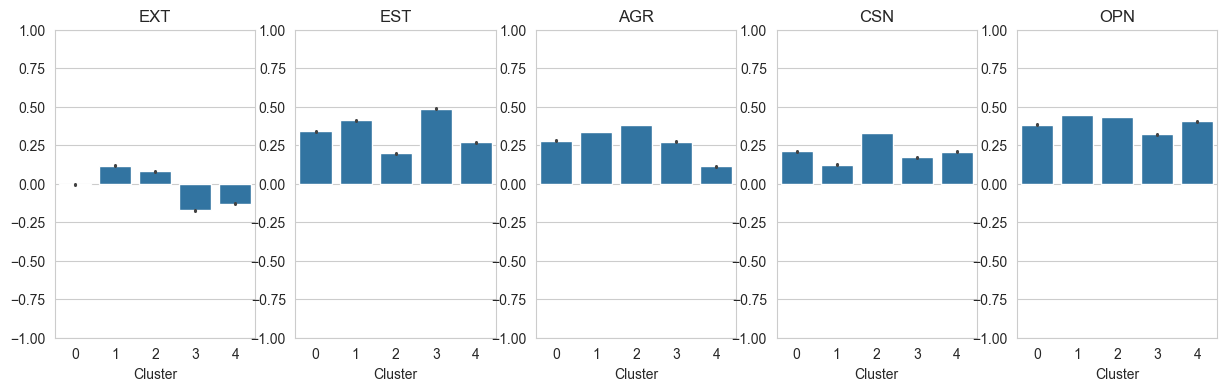

In [11]:
plt.figure(figsize=(15, 4))

for index, dimension in enumerate(dimensions):
    plt.subplot(1, 5, index+1)
    sns.barplot(data=study, x=cluster, y=dimension, estimator="mean")
    plt.xlabel("Cluster")
    plt.ylabel("")
    plt.ylim(-1, 1)
    plt.title(dimension)
plt.show()

We need to do a bit better.

## Time to improve

We have three areas to improve :
1. Feature selections : is it necessary to keep all the variables ?
2. PCA components : what is the optimal value for the number of components to keep ?
3. KMeans cluster : what is the optimal value for the number of clusters ?

We will focus only on the last two questions here, and left the first to the reader. Let's start with the PCA, as it will impact the clustering.

### PCA Components

We have a measure of explained variance, we shall use it. Before we need to *refresh* our dataset so that we do not keep previous transformations.

In [12]:
df = pd.read_csv("Analytica.csv")
X = df.drop(columns=["target"])
y = df["target"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Task** : Compute the explained variance for different values of components to keep.

In [13]:
explained_variance = []
components = range(2, X.shape[1])
for n_components in components:
    model_pca = PCA(n_components=n_components)
    model_pca.fit(X)
    explained_variance.append(model_pca.explained_variance_ratio_.sum())


**Task** : Display the result of the previous cell into a self explanatory plot. Use it to make a decision on the optimal number of components to keep.

Also bear in mind that the more components are kept, the less meaning distance will have for the KMeans clustering. 

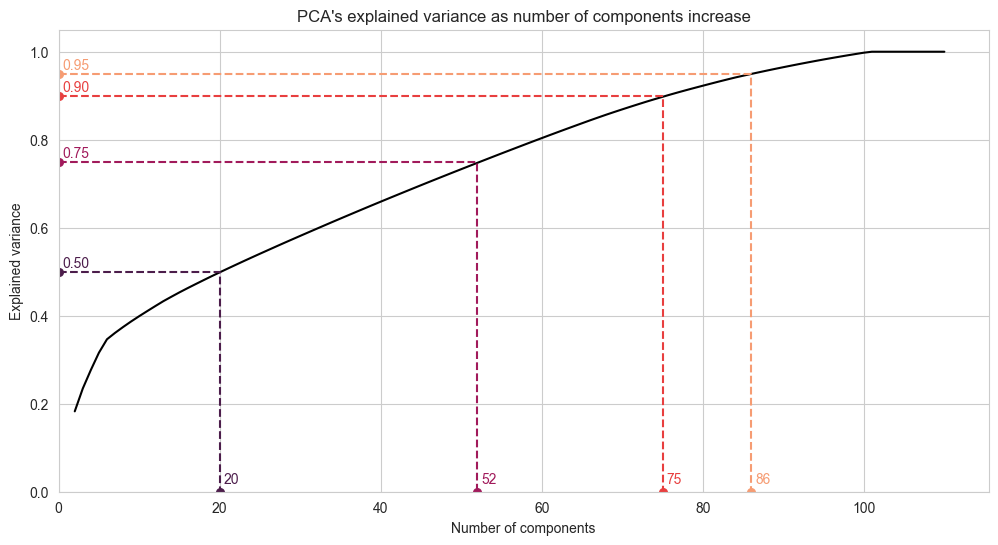

In [14]:
thresholds = [0.5, 0.75, 0.9, 0.95]


plt.figure(figsize=(12, 6))

plt.plot(components, explained_variance, color="black")


colors = sns.color_palette(palette="rocket", n_colors=len(thresholds))

for index, threshold in enumerate(thresholds):
    color = colors[index]
    n_components = np.argmax(np.array(explained_variance) >= threshold) + 1
    plt.plot([0, n_components, n_components], [threshold, threshold, 0], ls='--', color=color)

    plt.scatter(n_components, 0, s=30, color=color)
    plt.text(n_components + 0.5, 0.02, f'{n_components}', color=color)
    plt.scatter(0, threshold, s=30, color=color)
    plt.text(0.5, threshold+0.01, f'{threshold:.2f}', color=color)


plt.ylim(bottom=0)
plt.xlim(left=0)
plt.ylabel("Explained variance")
plt.xlabel("Number of components")
plt.title("PCA's explained variance as number of components increase")
plt.show()

**Task** : Given your previous analysis, use PCA to reduce dimension.

In [15]:
n_components = 52
model_pca = PCA(n_components=n_components)
model_pca.fit(X)
X_pca = model_pca.transform(X)

### Number of clusters

Now that we have an *optimal* feature matrix, we need to find the better number of cluster for the KMeans algorithm. The model, once trained, as an attribute `inertia` that can be tracked to get insights on how splitted the clusters are.

**Task** : Compute the inertia for several number of cluster, up to 30 for example.

In [16]:
inertias = []
clusters = range(2, 31)

for n_clusters in clusters:
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_pca)
    inertias.append(model.inertia_)


**Task** : Display the informations of the previous cell into a self-explanatory plot. Use it to make a decision on the optimal number of cluster.

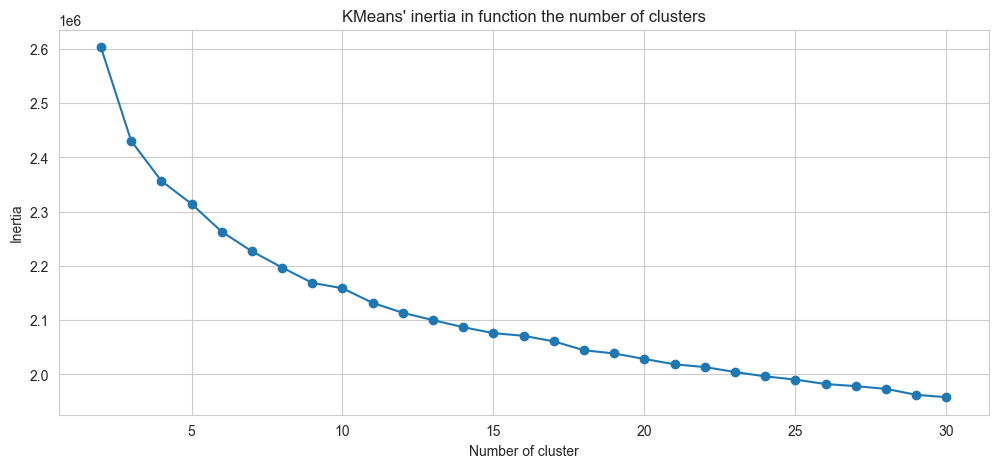

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(clusters, inertias, 'o-')
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title("KMeans' inertia in function the number of clusters")
plt.show()

In [18]:
model = KMeans(n_clusters=9)
model.fit(X_pca)
cluster = model.predict(X_pca)

**Task** : Adapt the following cells (if needed) given your previous choice, and the choices above.

We are creating a dataframe with two columns :
* **ID** : the identifier of the person
* **prediction** : your prediction on if he is going to vote for your candidate or not (0 / 1)
The dataframe must only contains the rows with no target known. The prediction will come from the average target in each cluster we build. We will predict 1 if the average is above 0.5, 0 instead.

In [32]:
study = df[["ID", "target"]]
study["Cluster"] = cluster
clusters = study.groupby(by="Cluster", as_index=False).agg("mean")[["Cluster", "target"]]
clusters.columns = ["Cluster", "Average"]

study = study.merge(clusters, on="Cluster")
study = study.loc[study["target"].isna(), ]
study["prediction"] = (study["Average"] > 0.5).astype(int)
answer = study[["ID", "prediction"]]
answer.head()

/var/folders/lf/gcppmty149qbrnk_k09vzs040000gn/T/ipykernel_53243/338147149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study["Cluster"] = cluster


,ID,prediction
0,20160303022202,1
2,20160303052049,1
3,20160303052319,0
5,20160303055318,1
6,20160303063505,0


**Task** : save the dataframe *answer* and submit your prediction on the [Kaggle competition](https://www.kaggle.com/t/4817e6d424c040a98571c0277e88b18a).

In [33]:
answer.to_csv("submit.csv", index=False)